In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.template_match_target import *
import cv2
import glob
import os
import h5py
import pandas as pd
%matplotlib inline

dim=256

def get_id(i, zeropad=5):
    return 'img_{i:0{zp}d}'.format(i=i, zp=zeropad)

In [10]:
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/final_data/ /Users/silburt/remotemount/")
dirssh = '/Users/silburt/remotemount'
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/r/rein/silburt/moon-craters/datasets/HEAD/ /Users/silburt/remotemount2/")
dirssh2 = '/Users/silburt/remotemount2'
dim=256

## MOON

In [14]:
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/newscripttest_for_ari/ /Users/silburt/remotemount3/")
dirssh3 = '/Users/silburt/remotemount3'

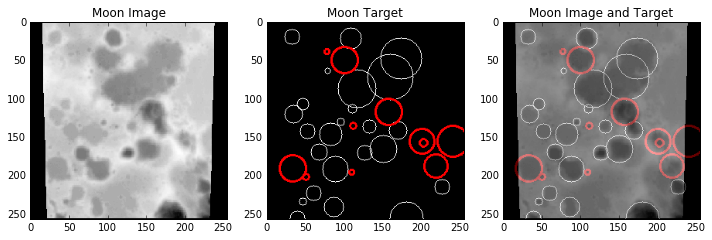

In [40]:
dtype = 'dev'
imgs = h5py.File('%s/%s_images.hdf5'%(dirssh3,dtype), 'r')
craters = pd.HDFStore('%s/%s_craters.hdf5'%(dirssh,dtype),'r')

#(dev,3) - many false negatives
i=3

img = imgs['input_images'][i]
img = img/255.
low,hi=0.01,1
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

csv = craters[get_id(i)]
csv = np.asarray((csv['x'],csv['y'],csv['Diameter (pix)']/2)).T
cimg = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR) 
for c in csv:
    x,y,r = c
    cv2.circle(cimg,(int(x),int(y)),int(r),(255,255,255),thickness=1)

#(dev,3)
missed_coords = [(100,50,17),(157,117,17),(33,190,17),(50,201,4),(200,155,16),
                 (202,157,5),(77,39,3),(218,187,15),(240,155,20),(109,195,3),
                 (111,135,4)]
for c in missed_coords:
    x,y,r = c
    cv2.circle(cimg,(int(x),int(y)),int(r),(255,0,0),thickness=2)
    
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[12, 4])
ax1.imshow(img.reshape(dim,dim),origin='upper', cmap="Greys_r")
#ax2.imshow(test_target[i],origin='upper', cmap="Greys_r")
ax2.imshow(cimg, origin='upper')
ax3.imshow(img.reshape(dim,dim),origin='upper', cmap="Greys_r")
ax3.imshow(cimg,origin='upper', alpha=0.4)

ax1.set_title('Moon Image')
ax2.set_title('Moon Target')
ax3.set_title('Moon Image and Target')
plt.savefig('images/paper_images/paper_DataTargetOverlap_Moon.png')

### Pred Comparison

In [11]:
dtype = 'dev'
imgs = h5py.File('%s/%s_images.hdf5'%(dirssh,dtype), 'r')
craters = pd.HDFStore('%s/%s_craters.hdf5'%(dirssh,dtype),'r')
preds = h5py.File('%s/HEAD_%spreds_n30000_final.hdf5'%(dirssh2,dtype), 'r')[dtype]

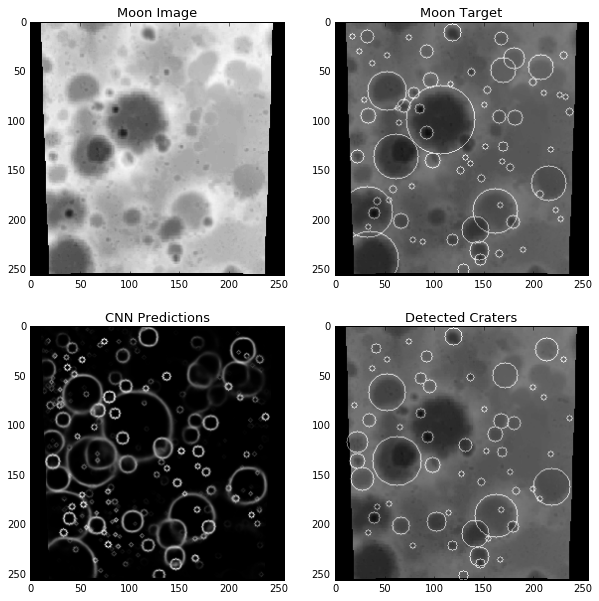

In [7]:
i = 15
coords = template_match_t(preds[i].copy(), minrad=3)

mask = np.zeros((dim,dim))
radii_dist = []
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 1)
    radii_dist.append(r)
    
img = imgs['input_images'][i]
img = img/255.
low,hi=0.1,1
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

target = imgs['target_masks'][i]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=[10, 10])
ax1.imshow(img.reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.imshow(img.reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.imshow(target.reshape(dim,dim), origin='upper', cmap="Greys_r",alpha=0.5)
ax3.imshow(preds[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax4.imshow(img.reshape(dim,dim), origin='upper', cmap="Greys_r")
ax4.imshow(mask, origin='upper', cmap="Greys_r",alpha=0.5)

fontsize=13
ax1.set_title('Moon Image',fontsize=fontsize)
ax2.set_title('Moon Target',fontsize=fontsize)
ax3.set_title('CNN Predictions',fontsize=fontsize)
ax4.set_title('Detected Craters',fontsize=fontsize)
plt.savefig('images/paper_DataTargetPredExtract_Moon.png')
#ax5.hist(radii_dist, 10)

# MERCURY

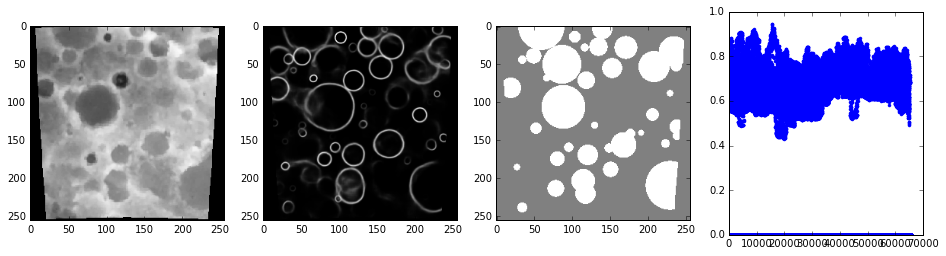

In [5]:
# General Plotting
train_data = np.load('catalogues/mercury/merc_0_input_charles.npy')/255.
train_target = np.load('catalogues/mercury/merc_0_targets_charles.npy')
preds = np.load('catalogues/mercury/merc_0_input_charles_modelpreds_n10_new.npy')

img = train_data[i]
img = img/255.
low,hi=0.1,1
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

i=6
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[16, 4])
ax1.imshow(img,origin='upper', cmap="Greys_r")
ax2.imshow(preds[i],origin='upper', cmap="Greys_r")
ax3.imshow(train_target[i],origin='upper', cmap="Greys_r",alpha=0.5)
ax4.plot(train_data[i].reshape(dim*dim,1), '.')

### Load pre-made Preds and Extract Craters

In [9]:
i=7
coords = template_match_t(preds[i].copy(),minrad=3)
mask = np.zeros((dim,dim))
for c in coords:
    x,y,r = c
    cv2.circle(mask, (x,y), r, 1, 2)

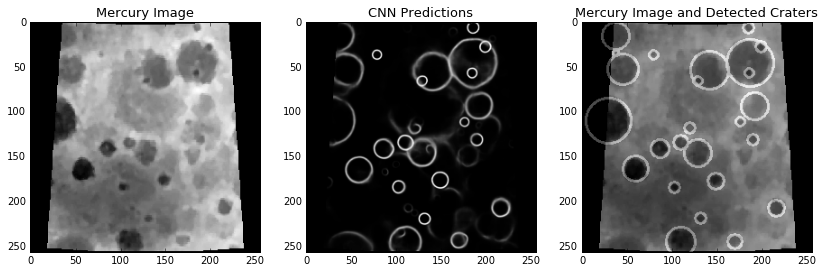

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 6])
img = train_data[i]
img = img/255.
low,hi=0.01,1
minn, maxx = np.min(img[img>0]), np.max(img[img>0])
img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

ax1.imshow(img,origin='upper', cmap="Greys_r")
ax2.imshow(preds[i],origin='upper', cmap="Greys_r")
ax3.imshow(img,origin='upper', cmap="Greys_r")
ax3.imshow(mask,origin='upper', cmap="Greys_r",alpha=0.3)

fontsize=13
ax1.set_title("Mercury Image",fontsize=fontsize)
ax2.set_title("CNN Predictions",fontsize=fontsize)
ax3.set_title("Mercury Image and Detected Craters",fontsize=fontsize)
plt.savefig("images/paper_DataPredOverlap_Mercury.png")
#plt.savefig("output_dir/images/Merc_preds_%d.png"%i)